# Finding the Key Using TRACES Sampled from Real Machines DPA
<div id=part2_dpa></div>

In [1]:
import csv
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

For this part we use real traces which were taken from FPGA which performed encryption using AES
The database for all samples at the time of the last round can be found in the file `"_DATA1_keyset_9_attack.csv"`

In [2]:
KEYSET_FILE_PATH  = "./Resources/_DATA1_keyset_9_attack.csv"
DOM_OUT_PATH = "./Resources/DoM_Ex_Sample.dat"

In [3]:
wstart = 10
wstop = 1999
wlen = wstop-wstart
InvSbox = (
    0x52, 0x09, 0x6A, 0xD5, 0x30, 0x36, 0xA5, 0x38, 0xBF, 0x40, 0xA3, 0x9E, 0x81, 0xF3, 0xD7, 0xFB,
    0x7C, 0xE3, 0x39, 0x82, 0x9B, 0x2F, 0xFF, 0x87, 0x34, 0x8E, 0x43, 0x44, 0xC4, 0xDE, 0xE9, 0xCB,
    0x54, 0x7B, 0x94, 0x32, 0xA6, 0xC2, 0x23, 0x3D, 0xEE, 0x4C, 0x95, 0x0B, 0x42, 0xFA, 0xC3, 0x4E,
    0x08, 0x2E, 0xA1, 0x66, 0x28, 0xD9, 0x24, 0xB2, 0x76, 0x5B, 0xA2, 0x49, 0x6D, 0x8B, 0xD1, 0x25,
    0x72, 0xF8, 0xF6, 0x64, 0x86, 0x68, 0x98, 0x16, 0xD4, 0xA4, 0x5C, 0xCC, 0x5D, 0x65, 0xB6, 0x92,
    0x6C, 0x70, 0x48, 0x50, 0xFD, 0xED, 0xB9, 0xDA, 0x5E, 0x15, 0x46, 0x57, 0xA7, 0x8D, 0x9D, 0x84,
    0x90, 0xD8, 0xAB, 0x00, 0x8C, 0xBC, 0xD3, 0x0A, 0xF7, 0xE4, 0x58, 0x05, 0xB8, 0xB3, 0x45, 0x06,
    0xD0, 0x2C, 0x1E, 0x8F, 0xCA, 0x3F, 0x0F, 0x02, 0xC1, 0xAF, 0xBD, 0x03, 0x01, 0x13, 0x8A, 0x6B,
    0x3A, 0x91, 0x11, 0x41, 0x4F, 0x67, 0xDC, 0xEA, 0x97, 0xF2, 0xCF, 0xCE, 0xF0, 0xB4, 0xE6, 0x73,
    0x96, 0xAC, 0x74, 0x22, 0xE7, 0xAD, 0x35, 0x85, 0xE2, 0xF9, 0x37, 0xE8, 0x1C, 0x75, 0xDF, 0x6E,
    0x47, 0xF1, 0x1A, 0x71, 0x1D, 0x29, 0xC5, 0x89, 0x6F, 0xB7, 0x62, 0x0E, 0xAA, 0x18, 0xBE, 0x1B,
    0xFC, 0x56, 0x3E, 0x4B, 0xC6, 0xD2, 0x79, 0x20, 0x9A, 0xDB, 0xC0, 0xFE, 0x78, 0xCD, 0x5A, 0xF4,
    0x1F, 0xDD, 0xA8, 0x33, 0x88, 0x07, 0xC7, 0x31, 0xB1, 0x12, 0x10, 0x59, 0x27, 0x80, 0xEC, 0x5F,
    0x60, 0x51, 0x7F, 0xA9, 0x19, 0xB5, 0x4A, 0x0D, 0x2D, 0xE5, 0x7A, 0x9F, 0x93, 0xC9, 0x9C, 0xEF,
    0xA0, 0xE0, 0x3B, 0x4D, 0xAE, 0x2A, 0xF5, 0xB0, 0xC8, 0xEB, 0xBB, 0x3C, 0x83, 0x53, 0x99, 0x61,
    0x17, 0x2B, 0x04, 0x7E, 0xBA, 0x77, 0xD6, 0x26, 0xE1, 0x69, 0x14, 0x63, 0x55, 0x21, 0x0C, 0x7D,
)

## Section 1

Perform DoM based on real data

In [4]:
dom_arr = np.zeros((256,wlen),dtype='float')
sarr_a = np.array([0]*wlen)
sarr_b = np.array([0]*wlen)
ntraces_a = 0
ntraces_b = 0
number_of_traces = 2000

In [5]:
csv_reader_data = []
with open(KEYSET_FILE_PATH) as csv_file:
        temp_csv_reader = csv.reader(csv_file, delimiter=',')
        for row in temp_csv_reader:
            csv_reader_data.append(row)
N = (len(csv_reader_data[0])-2)
print(f"Total samples:{len(csv_reader_data)} and N={N}")

Total samples:8939 and N=2001


In [6]:
#display(pd.DataFrame(csv_reader_data, columns=["PT","CT"] + [f"T{i}" for i in range(1,N+1)]))

In [10]:
print_every = 10
if os.path.exists(DOM_OUT_PATH):
    with open(DOM_OUT_PATH,"r") as fp: 
        for KeyGuess,line in enumerate(fp): 
            if (KeyGuess % print_every == 0):
                print("Processing: "+ hex(KeyGuess))
            dom_arr[KeyGuess] = line.split()
    print("DoM computation Complete")
else:
    with open(DOM_OUT_PATH,"w") as fp: 
        for KeyGuess in range(0,256):
            if (KeyGuess % print_every == 0):
                print("Processing: "+ hex(KeyGuess))
            dofmean=np.zeros(wlen,dtype='float')
            csv_reader = csv_reader_data
            for row in csv_reader_data:
                ct = int(row[1],16)
                ct_temp=ct>>120

                # write the DoM computation code here
                # Update the variable sarr_a and sarr_b depending
                # upon the lsb of the hypothetical leakage value
                ################ My Code #######################

                BIT_MASK = 2**0
                r9_temp = InvSbox[ct_temp ^ KeyGuess]
                select_bit = 0 if (r9_temp & BIT_MASK == 0) else 1

                ### Sum traces power by bit value
                if select_bit == 0:
                    sarr_a += np.array([int(row[j],16) for j in range(wstart,wstop)])
                    ntraces_a += 1
                else:
                    sarr_b += np.array([int(row[j],16) for j in range(wstart,wstop)])
                    ntraces_b += 1

                ################################################
            # Update the valriable marr_a and marr_b with the mean of sarr_a
            # and sarr_b and compute the DoM value in the variable dofmean
            marr_a = 1.0 * sarr_a / ntraces_a
            marr_b = 1.0 * sarr_b / ntraces_b
            dofmean = np.abs(marr_a-marr_b)

            dom_arr[KeyGuess] = dofmean
            fp.write(' '.join(map(str, dofmean)) + "\n")
            ntraces_a=0
            ntraces_b=0
            sarr_a = np.array([0]*wlen)
            sarr_b = np.array([0]*wlen)
            del dofmean
    print("DoM computation Complete")

Processing: 0x0
Processing: 0xa
Processing: 0x14
Processing: 0x1e
Processing: 0x28
Processing: 0x32
Processing: 0x3c
Processing: 0x46
Processing: 0x50
Processing: 0x5a
Processing: 0x64
Processing: 0x6e
Processing: 0x78
Processing: 0x82
Processing: 0x8c
Processing: 0x96
Processing: 0xa0
Processing: 0xaa
Processing: 0xb4
Processing: 0xbe
Processing: 0xc8
Processing: 0xd2
Processing: 0xdc
Processing: 0xe6
Processing: 0xf0
Processing: 0xfa
DoM computation Complete


In other words we created a table in which for each column (ie an approximate value of a key) find the correlation coefficient of the row with each of the rows of the table from the file

In [11]:
df = pd.DataFrame(dom_arr, columns=[f"T{i}" for i in range(1,wlen+1)]).transpose()
display(df)

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
T1,0.008203,0.031416,0.031150,0.006729,0.026068,0.030651,0.005018,0.002068,0.044610,0.061840,...,0.004748,0.009740,0.001145,0.024015,0.042927,0.031730,0.036300,0.006123,0.008899,0.012983
T2,0.024229,0.022270,0.007045,0.010774,0.012368,0.008872,0.004974,0.023640,0.054197,0.067949,...,0.018774,0.024634,0.010623,0.021711,0.064122,0.027458,0.000930,0.014368,0.036440,0.005880
T3,0.010433,0.004152,0.019493,0.031393,0.018453,0.023216,0.010724,0.006057,0.043513,0.042828,...,0.020104,0.010747,0.045357,0.031525,0.053406,0.006567,0.001762,0.010637,0.016693,0.027355
T4,0.018925,0.030998,0.023461,0.040337,0.011969,0.002295,0.014775,0.014135,0.058273,0.020013,...,0.021895,0.003130,0.014167,0.021685,0.008206,0.002090,0.000418,0.007065,0.009542,0.036305
T5,0.036331,0.014211,0.033703,0.013914,0.018647,0.015287,0.044271,0.020926,0.040337,0.002774,...,0.008479,0.025522,0.008630,0.027967,0.026091,0.024769,0.004061,0.010680,0.007786,0.000062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T1985,0.017962,0.016210,0.008430,0.010222,0.046686,0.012641,0.021807,0.039347,0.017836,0.008278,...,0.017823,0.026158,0.005465,0.052638,0.020842,0.005234,0.018555,0.001278,0.008042,0.008451
T1986,0.011926,0.037411,0.002673,0.005774,0.039436,0.018284,0.031276,0.019076,0.011311,0.033549,...,0.036903,0.010973,0.005829,0.031936,0.018479,0.000925,0.009017,0.006590,0.005562,0.007849
T1987,0.017373,0.033190,0.013643,0.016629,0.000826,0.026325,0.042299,0.027543,0.001114,0.033644,...,0.023641,0.009171,0.010363,0.033937,0.021407,0.026030,0.031845,0.014987,0.008582,0.012007
T1988,0.007473,0.030493,0.027612,0.035141,0.003909,0.016697,0.046329,0.004417,0.026007,0.012344,...,0.014294,0.021891,0.001092,0.060826,0.034384,0.021747,0.034159,0.007110,0.018813,0.000014


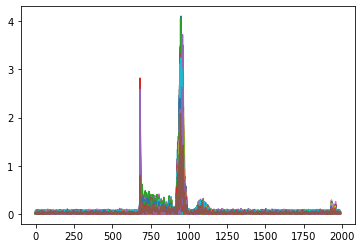

In [12]:
plt.plot(dom_arr.transpose())
plt.show()

In [13]:
maxval=0
correct_key = float("nan")
for i in range(256):
    row=dom_arr[i]
    if(maxval<max(row)):
        maxval=max(row)
        correct_key=i
        correct_row=row
        
print ("correct_key_byte = " + hex(correct_key))

correct_key_byte = 0xbe


/Users/thorodin/miniconda3/envs/cs236781-hw/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  from ipykernel import kernelapp as app
/Users/thorodin/miniconda3/envs/cs236781-hw/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


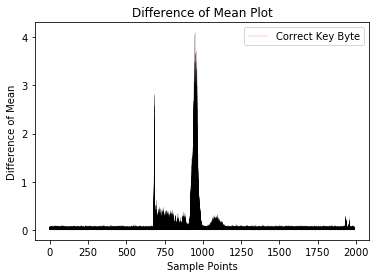

In [14]:
fig, ax1 = plt.subplots()
for i in range(256):
    row=dom_arr[i]
    tp=range(len(row))
    if (i == correct_key):
        plt.plot(range(len(correct_row)),correct_row , 'r', linewidth=0.2,label='Correct Key Byte')
    else:
        plt.plot(tp, row, 'k', linewidth=0.2)

ax1.legend()
plt.locator_params(axis='y', nbins=5)
plt.title('Difference of Mean Plot')
plt.xlabel('Sample Points')
plt.ylabel('Difference of Mean')
plt.savefig("DOM_AllKeyByte.png",dpi=1200,bbox_inches='tight')
plt.show()